### Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from skimage.metrics import structural_similarity as ssim

from google.colab import files
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

# A. LOAD AND SCALE DATA

Saving Fashion.png to Fashion.png


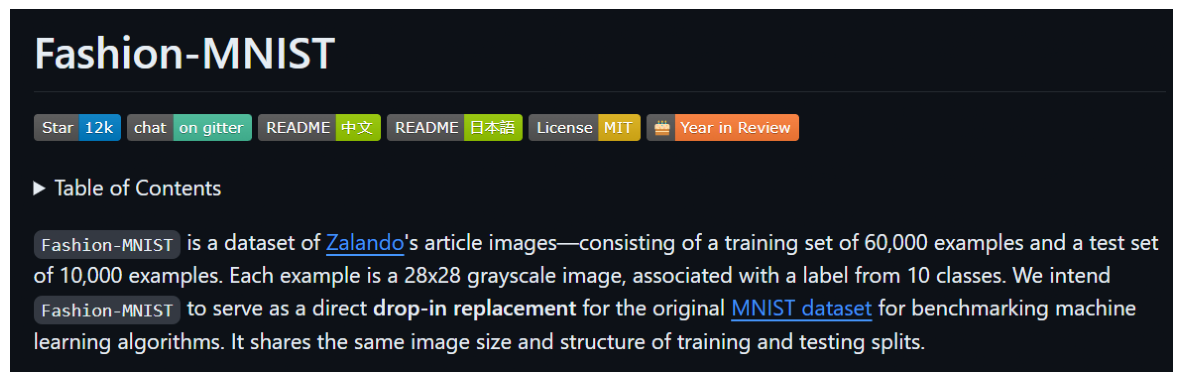

In [3]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
img = mpimg.imread(file_name)
plt.figure(figsize=(15, 25))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

### Load the Data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


Print shape dari train dan test data untuk images dan labels nya. Pastikan sudah sesuai dengan data fashion-mnist yang terdiri dari 60,000 training images dan 10,000 training images

In [ ]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


Print unique labels untuk dataset train dan test

In [ ]:
print("Unique labels in training set:", np.unique(train_labels))
print("Unique labels in test set:", np.unique(test_labels))

Unique labels in training set: [0 1 2 3 4 5 6 7 8 9]
Unique labels in test set: [0 1 2 3 4 5 6 7 8 9]


Berdasarkan informasi labels dari https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md, diketahui bahwa
T-shirt/top memiliki label 0 dan Trouser memiliki label 1

Saving Labels.png to Labels (1).png


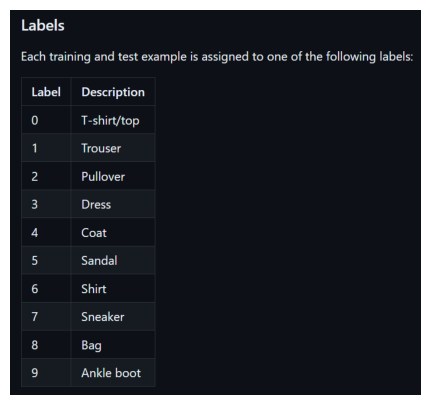

In [5]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
img = mpimg.imread(file_name)
plt.figure(figsize=(10, 5))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Melakukan filter hanya untuk class T-shirt/top (0) and Trouser (1) karena NIM Genap dan Gender Laki-laki

In [ ]:
train_filter = np.where((train_labels == 0) | (train_labels == 1))
test_filter = np.where((test_labels == 0) | (test_labels == 1))

train_images, train_labels = train_images[train_filter], train_labels[train_filter]
test_images, test_labels = test_images[test_filter], test_labels[test_filter]

In [ ]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (12000, 28, 28)
Train labels shape: (12000,)
Test images shape: (2000, 28, 28)
Test labels shape: (2000,)


Menggabungkan kedua train dan test dataset untuk proses splitting

In [ ]:
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

Print shape dari data setelah digabungkan

In [ ]:
print("All data shape:", all_images.shape, all_labels.shape)

All data shape: (14000, 28, 28) (14000,)


### Scale the Data

Gambar dinormalisasi ke rentang [0, 1] setelah dataset dipisahkan. Scaling ini perlu dilakukan agar data berada dalam rentang yang sama, sehingga model autoencoder dapat lebih mudah dan efisien dalam mengurangi dimensi data. Ini membantu autoencoder untuk belajar representasi yang lebih baik dan stabil selama pelatihan, mempercepat konvergensi dan meningkatkan kinerja.

In [ ]:
all_images = all_images / 255.0

### Split the Data

Lakukan pengacakan pada dataset untuk memastikan distribusi acak.

In [ ]:
indices = np.arange(all_images.shape[0])
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]

Lakukan Split pada dataset: 80% training, 10% validation, 10% test

In [ ]:
num_train = int(0.8 * all_images.shape[0])
num_val = int(0.1 * all_images.shape[0])

In [ ]:
train_images, train_labels = all_images[:num_train], all_labels[:num_train]
val_images, val_labels = all_images[num_train:num_train + num_val], all_labels[num_train:num_train + num_val]
test_images, test_labels = all_images[num_train + num_val:], all_labels[num_train + num_val:]

Print shape dari data setelah dilakukan split

In [ ]:
print("Training data shape:", train_images.shape, train_labels.shape)
print("Validation data shape:", val_images.shape, val_labels.shape)
print("Testing data shape:", test_images.shape, test_labels.shape)

Training data shape: (11200, 28, 28) (11200,)
Validation data shape: (1400, 28, 28) (1400,)
Testing data shape: (1400, 28, 28) (1400,)


### Display the Data

Membuat function untuk display gambar kedua kelas, masing-masing untuk train, test, dan val

In [ ]:
def display_sample_images(images, labels, title):
    plt.figure(figsize=(10, 5))
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        index = np.where(labels == label)[0][0]
        plt.subplot(1, len(unique_labels), i+1)
        plt.imshow(images[index], cmap='gray')
        plt.title(f"{title} - Class {label}")
        plt.axis('off')
    plt.show()

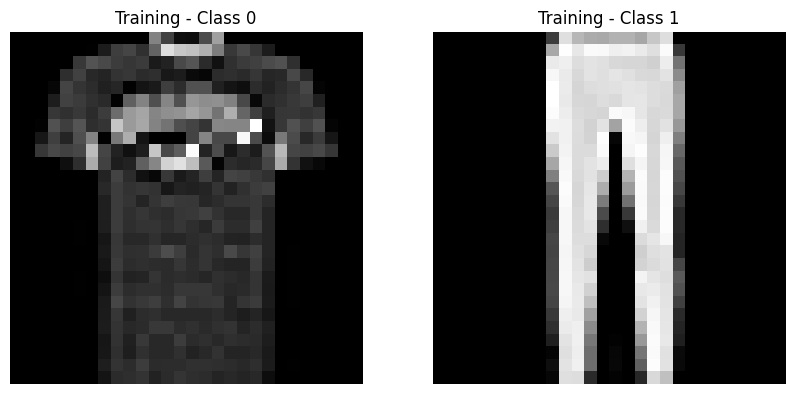

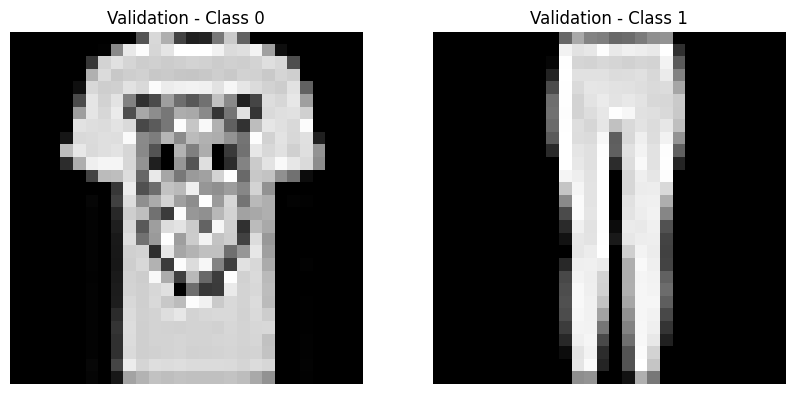

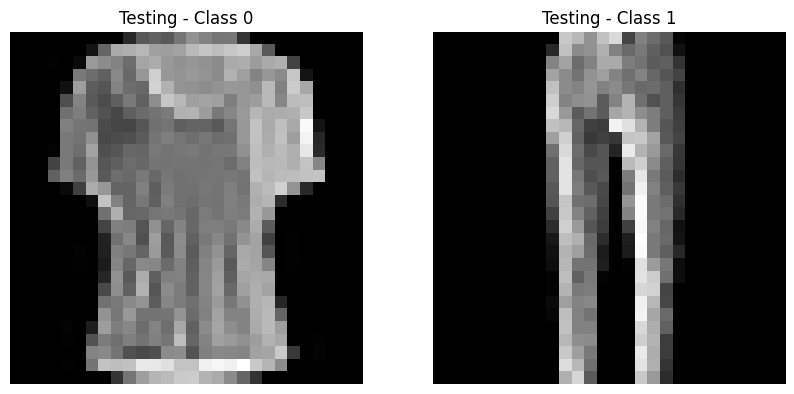

In [ ]:
display_sample_images(train_images, train_labels, "Training")
display_sample_images(val_images, val_labels, "Validation")
display_sample_images(test_images, test_labels, "Testing")

# B. BASELINE ARCHITECTURE

## Reshape the Data

Saya melakukan dimension expansion pada `train_images`, `val_images`, dan `test_images` untuk menambahkan dimensi channel pada gambar. Hal ini dilakukan karena gambar dalam dataset Fashion MNIST awalnya memiliki bentuk `(28, 28)`, sedangkan Convolutional Neural Network (CNN) dalam TensorFlow/Keras mengharapkan input dengan bentuk `(height, width, channels)`.

Dalam kasus gambar grayscale seperti pada dataset Fashion MNIST, jumlah channel adalah 1. Oleh karena itu, bentuk akhir dari gambar harus menjadi `(28, 28, 1)`. Proses ini memastikan bahwa data memiliki bentuk yang benar untuk digunakan sebagai input dalam lapisan konvolusi model autoencoder.

In [ ]:
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

In [ ]:
print("Training data shape:", train_images.shape)
print("Validation data shape:", val_images.shape)
print("Testing data shape:", test_images.shape)

Training data shape: (11200, 28, 28, 1)
Validation data shape: (1400, 28, 28, 1)
Testing data shape: (1400, 28, 28, 1)


Saving Architecture.png to Architecture (5).png


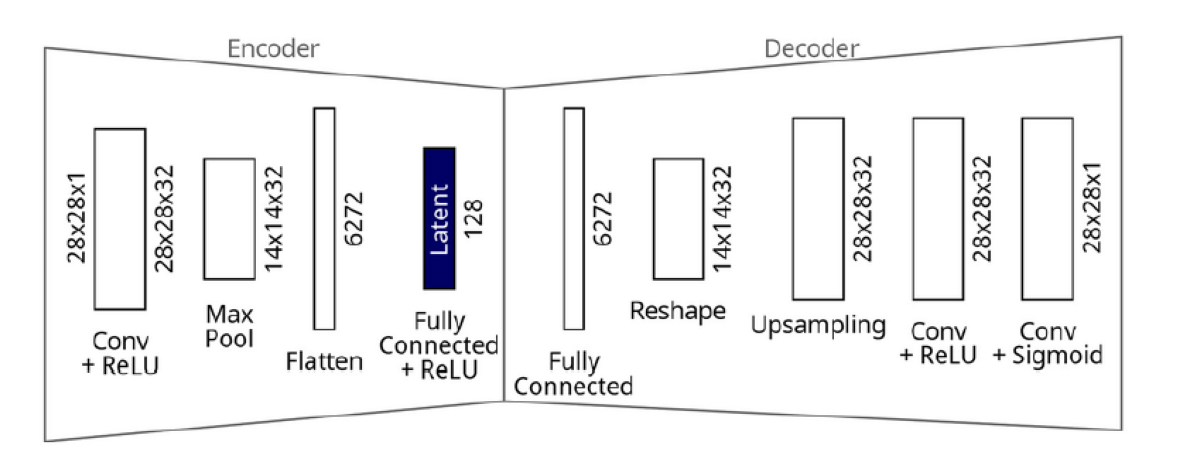

In [ ]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
img = mpimg.imread(file_name)
plt.figure(figsize=(15, 25))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Arsitektur autoencoder pada gambar diatas terdiri dari dua bagian utama: encoder dan decoder.

### Encoder
1. **Input Layer (28x28x1)**:
   - Gambar input dengan ukuran 28x28 piksel dan 1 saluran (grayscale).

2. **Convolutional Layer (Conv + ReLU)**:
   - Lapisan konvolusi dengan 32 filter, kernel 3x3, dan fungsi aktivasi ReLU. Hasilnya adalah tensor berukuran 28x28x32.

3. **Max Pooling Layer**:
   - Lapisan max pooling dengan ukuran pool 2x2, yang mengurangi dimensi tensor menjadi 14x14x32.

4. **Flatten Layer**:
   - Tensor diubah menjadi vektor satu dimensi berukuran 6272 (14x14x32).

5. **Fully Connected Layer (Dense + ReLU)**:
   - Lapisan dense dengan 128 unit dan fungsi aktivasi ReLU, menghasilkan representasi laten berukuran 128.

### Decoder
1. **Fully Connected Layer (Dense + ReLU)**:
   - Lapisan dense yang mengubah representasi laten kembali ke ukuran 6272.

2. **Reshape Layer**:
   - Vektor satu dimensi diubah kembali menjadi tensor berukuran 14x14x32.

3. **Upsampling Layer**:
   - Lapisan upsampling yang meningkatkan ukuran tensor menjadi 28x28x32.

4. **Convolutional Layer (Conv + ReLU)**:
   - Lapisan konvolusi dengan 32 filter, kernel 3x3, dan fungsi aktivasi ReLU, mempertahankan ukuran tensor 28x28x32.

5. **Convolutional Layer (Conv + Sigmoid)**:
   - Lapisan konvolusi dengan 1 filter, kernel 3x3, dan fungsi aktivasi sigmoid, menghasilkan gambar rekonstruksi dengan ukuran 28x28x1.

Arsitektur ini mengompresi gambar input menjadi representasi laten yang lebih kecil di bagian encoder, dan kemudian mengembangkannya kembali menjadi gambar asli di bagian decoder. Lapisan konvolusi digunakan untuk ekstraksi fitur, lapisan pooling dan upsampling untuk pengurangan dan peningkatan dimensi, serta lapisan dense untuk transformasi data. Representasi laten yang lebih kecil membantu dalam memahami dan mengkodekan fitur penting dari gambar input.

## Define the Autoencoder Model

### Encoder

In [ ]:
latent_dim = 128

In [ ]:
encoder_input = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
encoder_output = layers.Dense(latent_dim, activation='relu')(x)

In [ ]:
encoder = models.Model(encoder_input, encoder_output, name='encoder')

### Decoder

In [ ]:
decoder_input = layers.Dense(6272, activation='relu')(encoder_output)
x = layers.Reshape((14, 14, 32))(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

### Train the Autoencoder

In [ ]:
autoencoder = models.Model(encoder_input, decoder_output, name='autoencoder')

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(train_images, train_images, epochs=50, batch_size=128, validation_data=(val_images, val_images))

Epoch 1/50
88/88 [==============================] - 1s 9ms/step - loss: 0.2391 - val_loss: 0.2438
Epoch 2/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2390 - val_loss: 0.2437
Epoch 3/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2390 - val_loss: 0.2438
Epoch 4/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2391 - val_loss: 0.2439
Epoch 5/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2390 - val_loss: 0.2437
Epoch 6/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2391 - val_loss: 0.2438
Epoch 7/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2390 - val_loss: 0.2437
Epoch 8/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2390 - val_loss: 0.2437
Epoch 9/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2390 - val_loss: 0.2439
Epoch 10/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2390 - val_loss: 0.2440
Epoch 11/50
88/88 [

In [ ]:
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

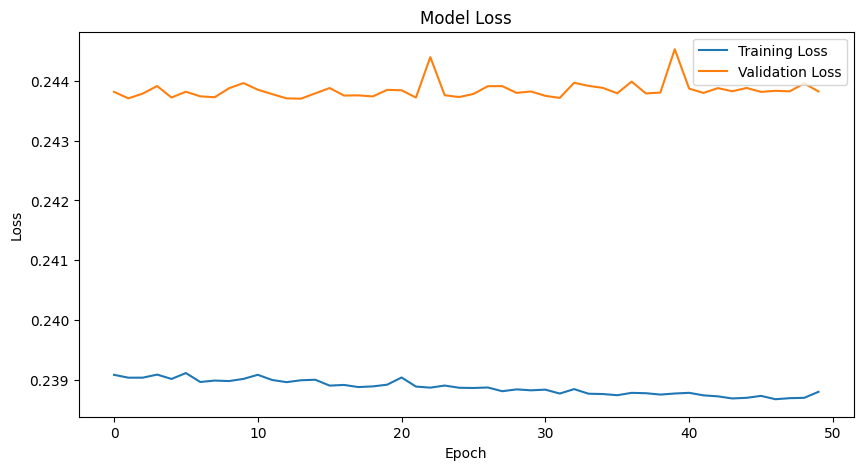

In [ ]:
plot_loss(history)

Hasil dari training autoencoder diatas menunjukkan bahwa baik loss pelatihan (training loss) maupun loss validasi (validation loss) tetap relatif stabil dan tidak mengalami perubahan signifikan selama 50 epoch. Nilai training loss berkisar sekitar 0.2387 hingga 0.2391, sementara nilai validation loss berkisar sekitar 0.2437 hingga 0.2445. Hal ini menunjukkan bahwa model mengalami kesulitan dalam memperbaiki rekonstruksi gambar lebih jauh setelah beberapa epoch awal, mungkin karena sudah mencapai batas kemampuan untuk dataset dan arsitektur yang digunakan. Tidak ada indikasi overfitting yang jelas, karena training loss dan validation loss tetap berada pada kisaran yang sama.

## Evaluation

Saving SSIM.png to SSIM (1).png


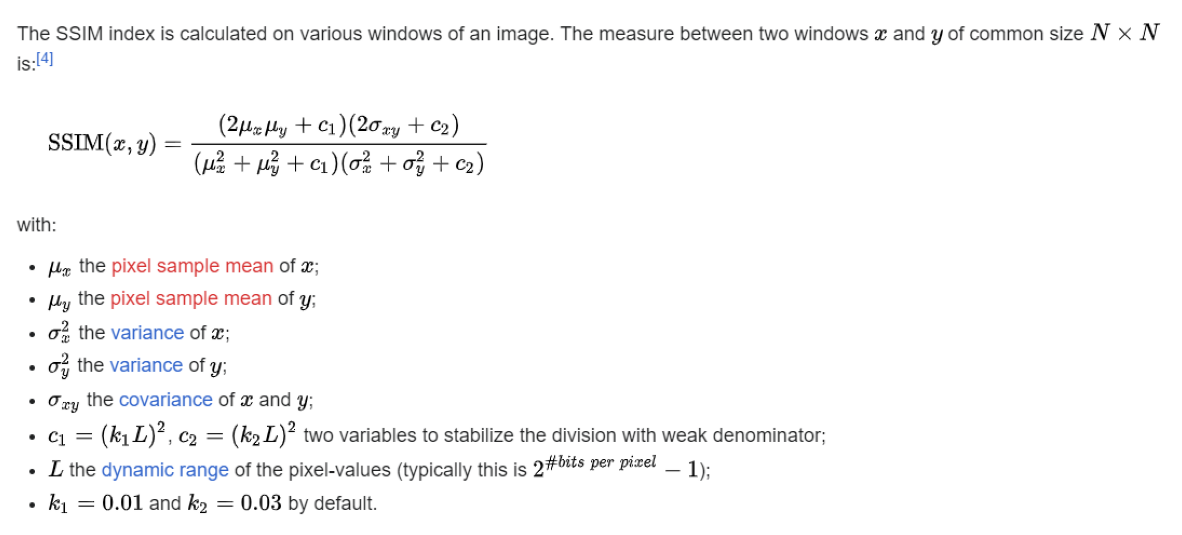

In [4]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
img = mpimg.imread(file_name)
plt.figure(figsize=(15, 20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

source: https://en.wikipedia.org/wiki/Structural_similarity_index_measure

SSIM (Structural Similarity Index) adalah metrik yang digunakan untuk mengukur kesamaan antara dua gambar. SSIM lebih canggih daripada metrik seperti MSE (Mean Squared Error) atau PSNR (Peak Signal-to-Noise Ratio) karena mempertimbangkan perubahan struktur lokal dalam gambar, yang lebih relevan untuk persepsi visual manusia.

Komponen-komponen SSIM:
SSIM dihitung berdasarkan tiga komponen utama:
1. Luminance (l(x,y)): Mengukur kesamaan rata-rata kecerahan antara dua gambar.
2. Contrast (c(x,y)): Mengukur kesamaan kontras antara dua gambar.
3. Structure (s(x,y)): Mengukur kesamaan pola struktur lokal antara dua gambar.

Dalam konteks autoencoder, SSIM digunakan untuk mengukur seberapa baik gambar yang dihasilkan (direkonstruksi) mirip dengan gambar asli. SSIM menghasilkan nilai antara -1 hingga 1, dimana:
- 1 menunjukkan kesamaan sempurna.
- 0 menunjukkan tidak ada kesamaan.
- Negatif menunjukkan ketidaksesuaian yang sangat besar (jarang terjadi dalam konteks gambar).

Untuk dataset seperti MNIST Fashion, nilai SSIM yang bagus biasanya mendekati 1, karena gambar-gambar ini relatif sederhana dan memiliki sedikit detail dibandingkan dengan gambar dunia nyata yang lebih kompleks. Dalam praktek, nilai SSIM yang bagus untuk autoencoder pada dataset ini biasanya berada di atas 0.90, yang menunjukkan bahwa gambar rekonstruksi sangat mirip dengan gambar asli.

Melakukan prediksi pada reconstructed images dari test set


In [ ]:
decoded_images = autoencoder.predict(test_images)

44/44 [==============================] - 0s 4ms/step


Function untuk menghitung SSIM (Structural Similarity Index)

In [ ]:
def calculate_ssim(original, reconstructed):
    ssim_values = []
    for i in range(original.shape[0]):
        ssim_value = ssim(original[i], reconstructed[i], multichannel=True)
        ssim_values.append(ssim_value)
    return ssim_values

Hitung SSIM pada test set

In [ ]:
ssim_values = calculate_ssim(test_images, decoded_images)
ssim_test = np.array(ssim_values)
print(f"Mean SSIM value for the test set: {np.mean(ssim_values)}")

Mean SSIM value for the test set: 0.9129812328269236


Function untuk memvisualisasikan SSIM value

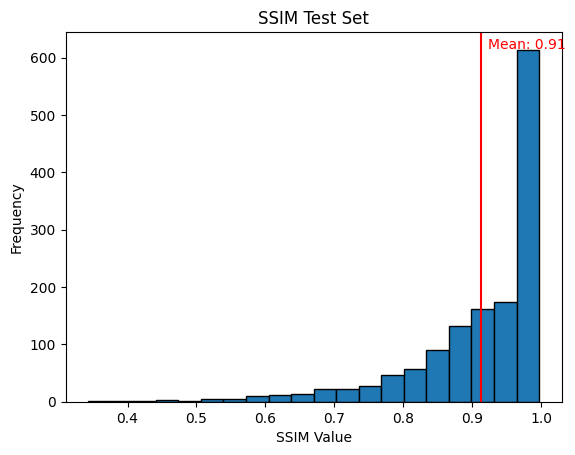

In [ ]:
h = plt.hist(ssim_test, bins=20, edgecolor='black')
plt.title("SSIM Test Set")
plt.axvline(ssim_test.mean(), color="r")
plt.text(ssim_test.mean() + 0.01, max(h[0]) + 1, "Mean: " + str(ssim_test.mean().round(2)), color='red')
plt.xlabel("SSIM Value")
plt.ylabel("Frequency")
plt.show()

Hasil histogram SSIM diatas menunjukkan distribusi left-tailed berarti bahwa mayoritas nilai SSIM untuk gambar test set sangat tinggi (dekat dengan 1), tetapi ada beberapa gambar yang memiliki nilai SSIM lebih rendah. Hal ini menunjukkan bahwa model autoencoder yang telah dibuat mampu merekonstruksi sebagian besar gambar dengan kualitas yang sangat baik, tetapi ada beberapa kasus di mana rekonstruksi tidak sebaik itu.

Beberapa alasan yang masuk akal mengapa hal tersebut bisa terjadi:
1. Autoencoder mungkin bekerja sangat baik untuk mayoritas gambar, tetapi tidak untuk beberapa gambar yang mungkin memiliki detail yang lebih kompleks atau noise yang lebih tinggi.
2. Karakteristik data tertentu mungkin lebih sulit direkonstruksi oleh autoencoder, sehingga menghasilkan nilai SSIM yang lebih rendah untuk beberapa gambar.
3. Model mungkin memerlukan lebih banyak epoch pelatihan untuk meningkatkan rekonstruksi gambar yang lebih sulit.

Menampilkan Original VS Reconstructed Image

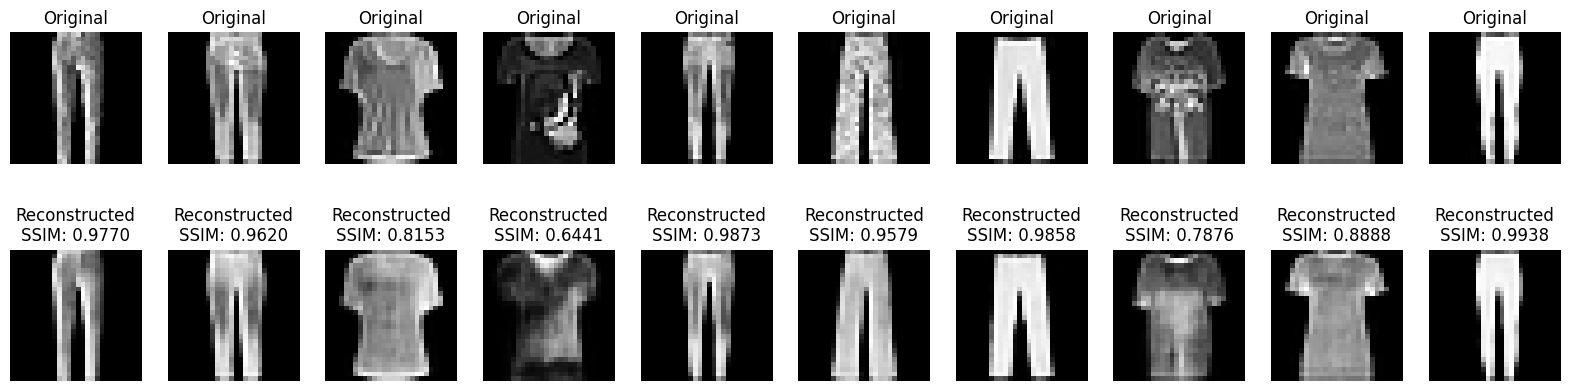

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Reconstructed\nSSIM: {ssim_values[i]:.4f}")
    plt.axis("off")
plt.show()

Hasil di atas menunjukkan perbandingan antara gambar asli (baris atas) dan gambar hasil rekonstruksi (baris bawah) dari test set menggunakan autoencoder. Nilai SSIM yang tinggi (mendekati 1) menunjukkan bahwa sebagian besar gambar direkonstruksi dengan sangat baik, mempertahankan banyak detail asli. Namun, beberapa gambar memiliki nilai SSIM yang lebih rendah, seperti yang terlihat pada contoh gambar keempat dari kiri dan ketiga dari kanan, yang menunjukkan bahwa model mengalami kesulitan dalam merekonstruksi gambar-gambar tersebut dengan baik, karena detail yang lebih kompleks atau variasi dalam gambar asli.

# C. ARCHITECTURE MODIFICATION

Berikut saya rincikan beberapa modifikasi yang saya lakukan:
1. **Penambahan Layer Convolution**:
    - **Sebelumnya**: Hanya satu convolution layer di encoder dan satu convolution layer di decoder.
    - **Sekarang**: Dua convolution layer di encoder dan dua convolution layer di decoder.
    - **Alasan**: Penambahan convolution layer memungkinkan model untuk menangkap lebih banyak fitur dari gambar, yang dapat meningkatkan kualitas rekonstruksi.

2. **Penambahan Lapisan Batch Normalization**:
    - **Sebelumnya**: Tidak ada batch normalization layer.
    - **Sekarang**: Batch normalization ditambahkan setelah setiap convolution dan dense layer di encoder dan decoder.
    - **Alasan**: Batch normalization membantu dalam menormalkan aktivasi, mempercepat pelatihan, dan meningkatkan stabilitas model.

3. **Penambahan Lapisan Dropout**:
    - **Sebelumnya**: Tidak ada dropout layer.
    - **Sekarang**: Dropout ditambahkan dengan rate 0.2 setelah Flatten layer di encoder dan sebelum layer terakhir di decoder.
    - **Alasan**: Dropout membantu mencegah overfitting dengan secara acak menonaktifkan sebagian neuron selama pelatihan, sehingga model menjadi lebih robust dan mampu generalisasi lebih baik pada data yang tidak terlihat.

4. **Dimensi Latent yang Lebih Tinggi**:
    - **Sebelumnya**: Dimensi latent space adalah 128.
    - **Sekarang**: Dimensi latent space ditingkatkan menjadi 256.
    - **Alasan**: Meningkatkan dimensi latent space memungkinkan model untuk menyimpan lebih banyak informasi, yang dapat menghasilkan rekonstruksi yang lebih baik dan lebih rinci.

5. **Penggunaan Optimizer dengan Learning Rate yang Disesuaikan**:
    - **Sebelumnya**: Menggunakan optimizer Adam dengan default learning rate.
    - **Sekarang**: Menggunakan optimizer Adam dengan learning rate yang diatur menjadi 0.001.
    - **Alasan**: Mengatur learning rate membantu dalam kontrol laju pembelajaran, memungkinkan model untuk beradaptasi lebih baik selama pelatihan dan mencapai konvergensi yang lebih optimal.

6. **Penambahan EarlyStopping Callback**:
    - **Sebelumnya**: Tidak ada early stopping.
    - **Sekarang**: Menggunakan early stopping dengan parameter patience 7 dan restore_best_weights=True.
    - **Alasan**: Early stopping mencegah overfitting dengan menghentikan pelatihan jika tidak ada peningkatan pada validation loss setelah beberapa epoch, serta memulihkan bobot terbaik yang dicapai selama pelatihan.

Dengan modifikasi ini, model autoencoder diharapkan dapat menghasilkan rekonstruksi gambar yang lebih baik dan lebih stabil selama pelatihan, yang tercermin dalam peningkatan nilai SSIM (Structural Similarity Index).

## Define the Modified Autoencoder Model

### Modified Encoder

In [ ]:
latent_dim_new = 256

In [ ]:
encoder_input_new = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input_new)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
encoder_output_new = layers.Dense(latent_dim_new, activation='relu')(x)

In [ ]:
encoder_new = models.Model(encoder_input_new, encoder_output_new, name='encoder_new')

### Modified Decoder

In [ ]:
decoder_input_new = layers.Dense(7 * 7 * 64, activation='relu')(encoder_output_new)
x = layers.Reshape((7, 7, 64))(decoder_input_new)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
decoder_output_new = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

### Train the Modified Autoencoder

In [ ]:
autoencoder_new = models.Model(encoder_input_new, decoder_output_new, name='autoencoder_new')

In [ ]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
autoencoder_new.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history_new = autoencoder_new.fit(
    train_images, train_images,
    epochs=100,
    batch_size=64,
    validation_data=(val_images, val_images),
    callbacks=[early_stopping]
)

Epoch 1/100
175/175 [==============================] - 6s 13ms/step - loss: 0.3215 - val_loss: 0.5150
Epoch 2/100
175/175 [==============================] - 2s 11ms/step - loss: 0.2632 - val_loss: 0.3919
Epoch 3/100
175/175 [==============================] - 2s 12ms/step - loss: 0.2566 - val_loss: 0.2633
Epoch 4/100
175/175 [==============================] - 2s 12ms/step - loss: 0.2528 - val_loss: 0.2505
Epoch 5/100
175/175 [==============================] - 2s 11ms/step - loss: 0.2509 - val_loss: 0.2524
Epoch 6/100
175/175 [==============================] - 2s 11ms/step - loss: 0.2500 - val_loss: 0.2481
Epoch 7/100
175/175 [==============================] - 2s 11ms/step - loss: 0.2487 - val_loss: 0.2508
Epoch 8/100
175/175 [==============================] - 2s 11ms/step - loss: 0.2474 - val_loss: 0.2468
Epoch 9/100
175/175 [==============================] - 2s 11ms/step - loss: 0.2467 - val_loss: 0.2461
Epoch 10/100
175/175 [==============================] - 2s 12ms/step - loss: 0.246

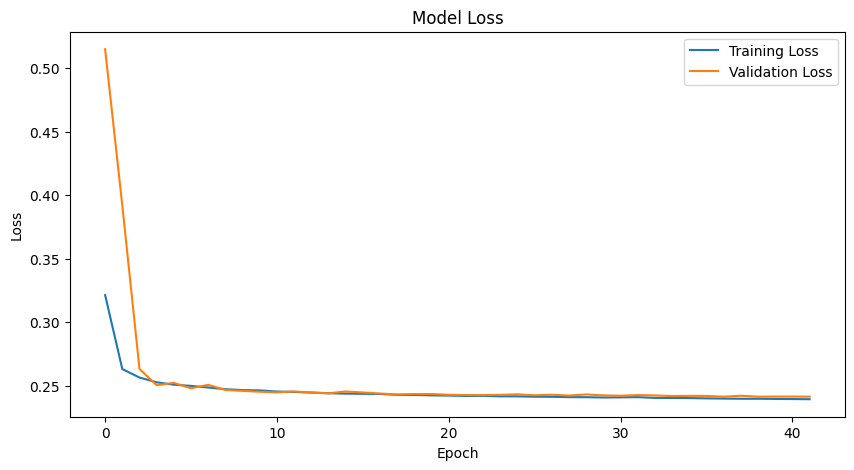

In [ ]:
plot_loss(history_new)

Hasil training menunjukkan bahwa baik training loss maupun validation loss turun tajam pada awal pelatihan dan stabil di sekitar 0.25 setelah 10 epoch. Ini menunjukkan model belajar dengan cepat dan kemudian mencapai kestabilan tanpa indikasi overfitting atau underfitting yang signifikan, menandakan bahwa modifikasi arsitektur berhasil meningkatkan performa model.

## Evaluation

In [ ]:
decoded_images_new = autoencoder_new.predict(test_images)

44/44 [==============================] - 0s 2ms/step


In [ ]:
ssim_values_new = calculate_ssim(test_images, decoded_images_new)
ssim_test_new = np.array(ssim_values_new)
print(f"Mean SSIM value for the test set: {np.mean(ssim_test_new)}")

Mean SSIM value for the test set: 0.9278023348270786


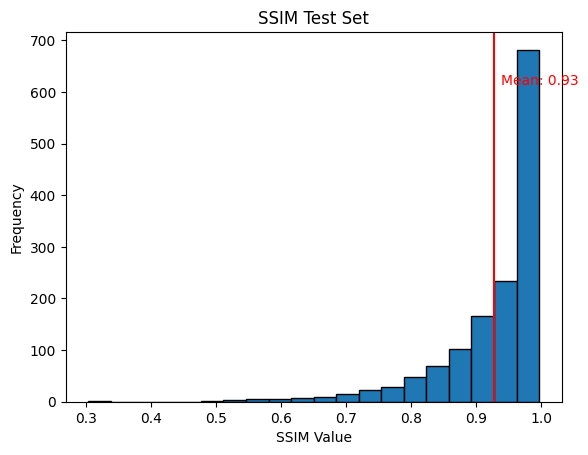

In [ ]:
h2 = plt.hist(ssim_test_new, bins=20, edgecolor='black')
plt.title("SSIM Test Set")
plt.axvline(ssim_test_new.mean(), color="r")
plt.text(ssim_test_new.mean() + 0.01, max(h[0]) + 1, "Mean: " + str(ssim_test_new.mean().round(2)), color='red')
plt.xlabel("SSIM Value")
plt.ylabel("Frequency")
plt.show()

Terjadi kenaikan nilai SSIM dari 0.913 menjadi 0.928 setelah modifikasi dilakukan. Peningkatan ini, meskipun kecil, menunjukkan bahwa modifikasi arsitektur memberikan dampak positif terhadap kemampuan autoencoder dalam merekonstruksi gambar. Penambahan lapisan konvolusi dan dekonvolusi memungkinkan model untuk menangkap lebih banyak fitur dari gambar, sementara lapisan Batch Normalization membantu dalam mempercepat pelatihan dan meningkatkan stabilitas model. Penambahan Dropout mencegah overfitting dengan mengurangi ko-dependensi neuron selama pelatihan. Dengan dimensi latent yang lebih tinggi, model dapat menyimpan lebih banyak informasi penting. Pengaturan learning rate yang tepat membantu model mencapai konvergensi yang lebih baik, dan EarlyStopping mencegah overfitting dengan menghentikan pelatihan pada waktu yang tepat.

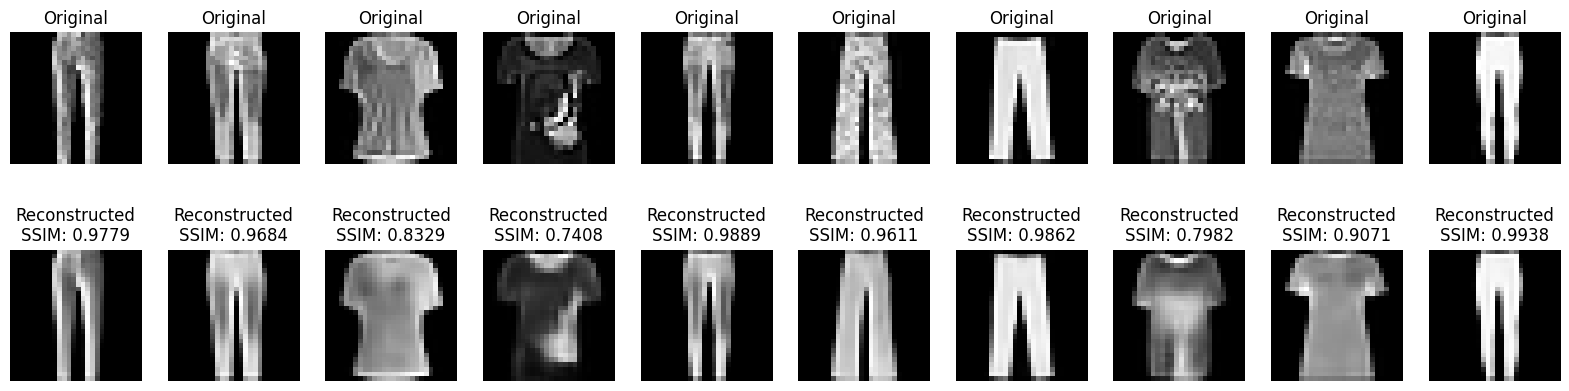

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_images_new[i].reshape(28, 28), cmap='gray')
    plt.title(f"Reconstructed\nSSIM: {ssim_values_new[i]:.4f}")
    plt.axis("off")
plt.show()

### Conclusion
Performa kedua model, baik baseline maupun modified, menunjukkan kemampuan yang baik dalam merekonstruksi gambar dari dataset Fashion MNIST, khususnya untuk kelas T-shirt/top dan Trouser. Model baseline sudah menunjukkan performa yang kuat dengan nilai SSIM rata-rata sebesar 0.913, yang menunjukkan rekonstruksi gambar yang sangat mirip dengan gambar asli. Namun, modifikasi arsitektur yang dilakukan, termasuk penambahan lapisan konvolusi dan dekonvolusi, Batch Normalization, Dropout, peningkatan dimensi latent, pengaturan learning rate, dan penggunaan EarlyStopping, menghasilkan peningkatan nilai SSIM menjadi 0.928. Peningkatan ini, meskipun kecil, menunjukkan bahwa modifikasi tersebut berhasil meningkatkan kualitas rekonstruksi dengan menangkap lebih banyak fitur dan mengurangi overfitting. Kesimpulannya, modifikasi arsitektur dan tuning hyperparameter memberikan dampak positif terhadap performa autoencoder, menghasilkan rekonstruksi gambar yang lebih baik dan lebih stabil.